In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import os
import cv2
#from keras.models import Sequential
#from keras.layers import Dense
#from sklearn.model_selection import StratifiedKFold
sns.set_style('darkgrid')
%matplotlib inline
#Test Train Split
from sklearn.model_selection import train_test_split
#Feature Scaling library
from sklearn.preprocessing import StandardScaler
#import pickle
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, LeakyReLU
from tensorflow.keras import regularizers, optimizers
from sklearn.metrics import r2_score
from tensorflow.keras.models import load_model

# **PART-A**

* <span style="color:#daad86">**DOMAIN**: <span style="color:#659dbd"> Entertainment

* <span style="color:#daad86">**CONTEXT**: <span style="color:#659dbd">Company X owns a movie application and repository which caters movie streaming to millions of users who on subscription basis.
Company wants to automate the process of cast and crew information in each scene from a movie such that when a user pauses on the movie
and clicks on cast information button, the app will show details of the actor in the scene. Company has an in-house computer vision and
multimedia experts who need to detect faces from screen shots from the movie scene.
The data labelling is already done.

* <span style="color:#daad86">**DATA DESCRIPTION**: <span style="color:#659dbd">The dataset comprises of images and its mask for corresponding human face.
    
* <span style="color:#daad86">**PROJECT OBJECTIVE**: <span style="color:#659dbd">To build a face detection system.

# **1. Import and Understand the data**

**A. Import and read ‘images.npy’.**

In [2]:
# Initialize the random number generator
import random
seed = 7
np.random.seed(seed)

# Ignore the warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
data = np.load('/content/drive/My Drive/AIML/Project2/Project2/images.npy',allow_pickle=True)

**B. Split the data into Features(X) & labels(Y). Unify shape of all the images.**

In [ ]:
data.shape

(409, 2)

In [ ]:
data[408][1]

[{'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.3201219512195122, 'y': 0.2839756592292089},
   {'x': 0.4009146341463415, 'y': 0.4198782961460446}],
  'imageWidth': 656,
  'imageHeight': 493},
 {'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.4557926829268293, 'y': 0.38742393509127787},
   {'x': 0.5442073170731707, 'y': 0.5618661257606491}],
  'imageWidth': 656,
  'imageHeight': 493},
 {'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.6707317073170732, 'y': 0.38336713995943206},
   {'x': 0.7134146341463414, 'y': 0.4746450304259635}],
  'imageWidth': 656,
  'imageHeight': 493},
 {'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.16615853658536586, 'y': 0.4665314401622718},
   {'x': 0.22560975609756098, 'y': 0.563894523326572}],
  'imageWidth': 656,
  'imageHeight': 493},
 {'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.07164634146341463, 'y': 0.539553752535497},
   {'x': 0.11280487804878049, 'y': 0.5862068965517241}],
  'imageWidth': 656,
  'imageHeight

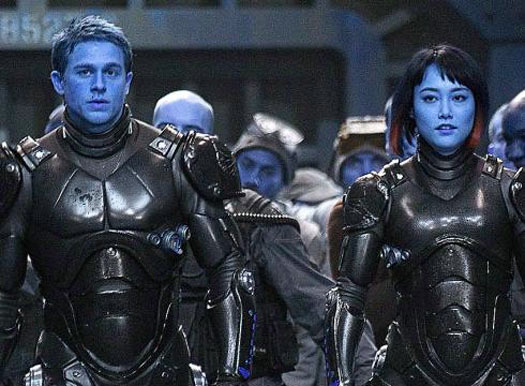

In [ ]:
from google.colab.patches import cv2_imshow

cv2_imshow(data[22][0])

In [ ]:
from tensorflow.keras.applications.mobilenet import preprocess_input

IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224

HEIGHT_CELLS = 28
WIDTH_CELLS = 28

IMAGE_SIZE = 224

masks = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH))
X = np.zeros((int(data.shape[0]),IMAGE_HEIGHT, IMAGE_WIDTH, 3))

for index in range(data.shape[0]):
  img = data[index][0]
  img = cv2.resize(img, dsize=(IMAGE_HEIGHT, IMAGE_WIDTH), interpolation=cv2.INTER_CUBIC)
  # assign all pixels in the first 3 channels only to the image, i.e., discard the alpha channel
  try:
    img = img[:,:,:3]
  except:
    print(f"Exception {index} Grayscale image with shape {img.shape}")
    # convert the grayscale image to color so that the number of channels are standardized to 3
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    continue
  X[index] = preprocess_input(np.array(img, dtype=np.float32))
  # Loop through the face co-ordinates and create mask out of it.
  for i in data[index][1]:
    x1 = int(i['points'][0]['x'] * IMAGE_WIDTH)
    x2 = int(i['points'][1]['x'] * IMAGE_WIDTH)
    y1 = int(i['points'][0]['y'] * IMAGE_HEIGHT)
    y2 = int(i['points'][1]['y'] * IMAGE_HEIGHT)
    # set all pixels within the mask co-ordinates to 1.
    masks[index][y1:y2, x1:x2] = 1
print(f"### Shape of X is '{X.shape}' and the shape of mask is '{masks.shape}' ")

Exception 272 Grayscale image with shape (224, 224)
### Shape of X is '(409, 224, 224, 3)' and the shape of mask is '(409, 224, 224)' 


**C. Split the data into train and test[400:9].**

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, masks, test_size=0.02)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.02)

print(f"Shape of X_train is '{X_train.shape}' and the shape of y_train is '{y_train.shape}'")
print(f"Shape of X_val is '{X_val.shape}' and the shape of y_val is '{y_val.shape}'")
print(f"Shape of X_test is '{X_test.shape}' and the shape of y_test is '{y_test.shape}'")

Shape of X_train is '(400, 224, 224, 3)' and the shape of y_train is '(400, 224, 224)'
Shape of X_val is '(8, 224, 224, 3)' and the shape of y_val is '(8, 224, 224)'
Shape of X_test is '(1, 224, 224, 3)' and the shape of y_test is '(1, 224, 224)'


**D. Select random image from the train data and display original image and masked image.**

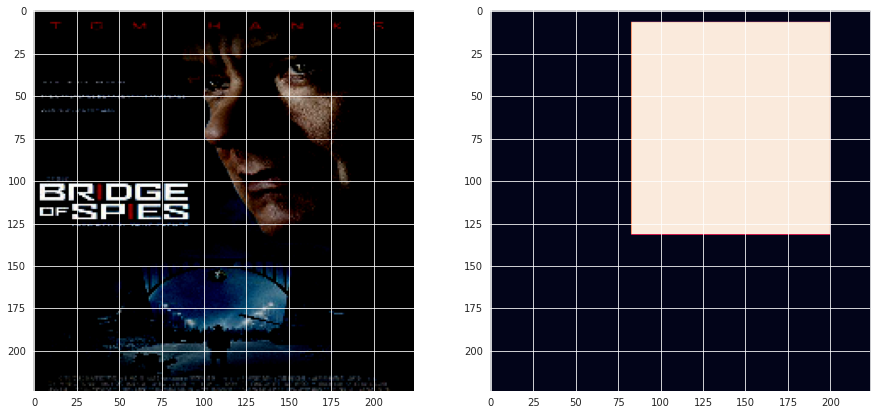

In [ ]:
num1 = random.randint(0, 400)
fig = plt.figure(figsize=(15, 15))
a = fig.add_subplot(1, 2, 1)
imgplot = plt.imshow(X_train[num1])
a = fig.add_subplot(1, 2, 2)
imgplot = plt.imshow(y_train[num1])

#  **2. Model building**

**A. Design a face mask detection model.**

In [ ]:
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Concatenate, UpSampling2D, Conv2D, Reshape
from tensorflow.keras.models import Model
import tensorflow as tf

HEIGHT_CELLS = 28
WIDTH_CELLS = 28
BATCH_SIZE = 1

In [ ]:
model = MobileNet(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), include_top=False, alpha=ALPHA, weights="imagenet")
model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

In [ ]:
def create_model(trainable=False):
    model = MobileNet(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), include_top=False, alpha=ALPHA, weights="imagenet")

    for layer in model.layers:
        layer.trainable = trainable
        
    block00 = model.layers[0].input
    block01 = model.get_layer("conv_pw_1_relu").output
    block02 = model.get_layer("conv_pw_2_relu").output
    block03 = model.get_layer("conv_pw_3_relu").output
    block05 = model.get_layer("conv_pw_5_relu").output
    block11 = model.get_layer("conv_pw_11_relu").output
    block13 = model.get_layer("conv_pw_13_relu").output

    decoderBlock = Concatenate()([UpSampling2D()(block13), block11])
    decoderBlock = Concatenate()([UpSampling2D()(decoderBlock), block05])
    decoderBlock = Concatenate()([UpSampling2D()(decoderBlock), block03])
    decoderBlock = Concatenate()([UpSampling2D()(decoderBlock), block01])
    decoderBlock = Concatenate()([UpSampling2D()(decoderBlock), block00])

    decoderBlock = Conv2D(1, kernel_size=1, activation="sigmoid")(decoderBlock)
    decoderBlock = Reshape((IMAGE_HEIGHT, IMAGE_WIDTH))(decoderBlock)

    return Model(inputs=model.input, outputs=decoderBlock) 

In [ ]:
model = create_model()

# Print summary
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_6[0][0]']                
                                )                                                                 
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 112, 112, 32  128         ['conv1[0][0]']                  
                                )                                                           

**B. Design your own Dice Coe icient and Loss function.**

**Define dice coefficient**

In [ ]:
def dice_coefficient(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)

    return numerator / (denominator + tf.keras.backend.epsilon())

**Define loss function**

In [ ]:
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.backend import log, epsilon
from tensorflow.keras.metrics import Recall, Precision
def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - log(dice_coefficient(y_true, y_pred) + epsilon())

**C. Train and tune the model as required.**

In [ ]:
model = create_model(False)
model.summary()
optimizer = tf.keras.optimizers.Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
metrics = [dice_coefficient, Recall(), Precision()]
model.compile(loss=loss, optimizer = optimizer, metrics=metrics)

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_10[0][0]']               
                                )                                                                 
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 112, 112, 32  128         ['conv1[0][0]']                  
                                )                                                           

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
checkpoint = ModelCheckpoint("model-{loss:.2f}.h5", monitor="loss", verbose=1, save_best_only=True,
                             save_weights_only=True, mode="min", save_freq=1)
stop = EarlyStopping(monitor="loss", patience=5, mode="min")
reduce_lr = ReduceLROnPlateau(monitor="loss", factor=0.2, patience=1, min_lr=1e-6, verbose=1, mode="min")

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint("model-{val_loss:.2f}.h5", monitor="val_loss", verbose=1, save_best_only=True, save_weights_only=True)

stop = EarlyStopping(monitor="val_loss", patience=5)

reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=5, min_lr=1e-6, verbose=1)

In [ ]:
model.fit(X_train,y_train, validation_data = (X_val, y_val),epochs = 40,verbose=1,batch_size=5,callbacks=[checkpoint,reduce_lr,stop])

Epoch 1/40
80/80 [==============================] - ETA: 0s - loss: 0.6404 - dice_coefficient: 0.6511 - recall: 0.7094 - precision: 0.7081
Epoch 1: val_loss did not improve from 0.77816
80/80 [==============================] - 16s 189ms/step - loss: 0.6404 - dice_coefficient: 0.6511 - recall: 0.7094 - precision: 0.7081 - val_loss: 0.7994 - val_dice_coefficient: 0.5479 - val_recall: 0.6061 - val_precision: 0.6070 - lr: 2.0000e-05
Epoch 2/40
80/80 [==============================] - ETA: 0s - loss: 0.6386 - dice_coefficient: 0.6508 - recall: 0.6923 - precision: 0.7217
Epoch 2: val_loss did not improve from 0.77816
80/80 [==============================] - 15s 187ms/step - loss: 0.6386 - dice_coefficient: 0.6508 - recall: 0.6923 - precision: 0.7217 - val_loss: 0.8007 - val_dice_coefficient: 0.5478 - val_recall: 0.6134 - val_precision: 0.6002 - lr: 2.0000e-05
Epoch 3/40
80/80 [==============================] - ETA: 0s - loss: 0.6360 - dice_coefficient: 0.6528 - recall: 0.7011 - precision: 0.

**D. Evaluate and share insights on performance of the model.**

We were able to get a decent Dice Coff which is above 50% and validation precision of about 60% which is still good outcome.

In [ ]:
test_steps = (len(X_test)//5)
if len(X_test) % 5 != 0:
    test_steps += 1
model.evaluate(X_test, y_test, steps=2)

1/2 [==============>...............] - ETA: 0s - loss: 1.3358 - dice_coefficient: 0.3462 - recall: 0.1693 - precision: 0.8360

2/2 [==============================] - 0s 32ms/step - loss: 1.3358 - dice_coefficient: 0.3462 - recall: 0.1693 - precision: 0.8360


[1.3357805013656616,
 0.3462469279766083,
 0.1693354696035385,
 0.8359683752059937]

# **3. Test the model predictions on the test image: ‘image with index 3 in the test data’ and visualise the predicted masks on the faces in the image.**

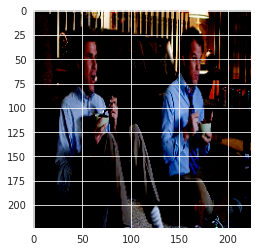

In [ ]:
plt.imshow(X_val[1])

1/1 [==============================] - 0s 18ms/step


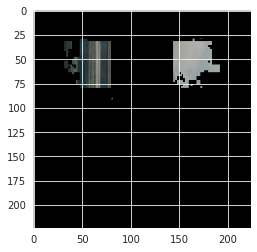

In [ ]:
# unscaled = cv2.imread(X_val[1])
# image = cv2.resize(unscaled, (IMAGE_WIDTH, IMAGE_HEIGHT))
# feat_scaled = preprocess_input(np.array(image, dtype=np.float32))

pred_mask = cv2.resize(1.0*(model.predict(x=np.array([X_val[1]]))[0] > 0.2), (IMAGE_WIDTH,IMAGE_HEIGHT))

image2 = image
image2[:,:,0] = pred_mask*image[:,:,0]
image2[:,:,1] = pred_mask*image[:,:,1]
image2[:,:,2] = pred_mask*image[:,:,2]

out_image = image2

plt.imshow(out_image)

In [ ]:
y_pred = model.predict(np.array([X_val[1]]))
y_pred

1/1 [==============================] - 0s 19ms/step


array([[[1.3418882e-03, 1.3430179e-03, 1.5262666e-03, ...,
         3.5557710e-05, 3.2505577e-05, 3.2723015e-05],
        [1.3435149e-03, 1.3407838e-03, 1.5236796e-03, ...,
         3.5668934e-05, 3.2579312e-05, 3.2668573e-05],
        [1.9161655e-03, 1.9115621e-03, 2.6426706e-03, ...,
         6.0896320e-05, 3.7901827e-05, 3.7853497e-05],
        ...,
        [4.3215761e-05, 4.3208798e-05, 7.3666954e-05, ...,
         1.2577900e-06, 1.0188520e-06, 1.0225687e-06],
        [3.3677821e-05, 3.3693083e-05, 3.4662935e-05, ...,
         8.3014936e-07, 1.1425616e-06, 1.1417501e-06],
        [3.3619002e-05, 3.3619002e-05, 3.4640463e-05, ...,
         8.3108966e-07, 1.1440237e-06, 1.1465074e-06]]], dtype=float32)

In [ ]:
pred_mask = cv2.resize((1.0*(y_pred[0] > 0.3)), (IMAGE_WIDTH,IMAGE_HEIGHT))

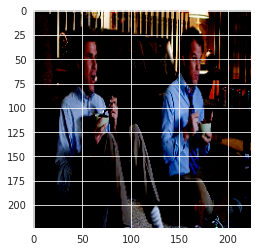

In [ ]:
plt.imshow(X_val[1])

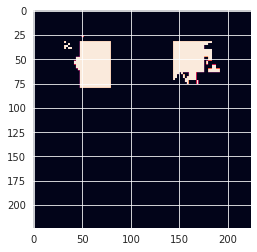

In [ ]:
plt.imshow(pred_mask)

# **Part B**

* <span style="color:#daad86">**DOMAIN**: <span style="color:#659dbd"> Entertainment

* <span style="color:#daad86">**CONTEXT**: <span style="color:#659dbd">Company X owns a movie application and repository which caters movie streaming to millions of users who on subscription basis.
Company wants to automate the process of cast and crew information in each scene from a movie such that when a user pauses on the movie
and clicks on cast information button, the app will show details of the actor in the scene. Company has an in-house computer vision and
multimedia experts who need to detect faces from screen shots from the movie scene.
The data labelling is already done.

* <span style="color:#daad86">**DATA DESCRIPTION**: <span style="color:#659dbd">The dataset comprises of face images.
    
* <span style="color:#daad86">**PROJECT OBJECTIVE**: <span style="color:#659dbd">To create an image dataset to be used by AI team build an image classifier data. Profile images of people are given.

In [ ]:
from tqdm.notebook import trange, tqdm
from IPython.display import Image, display, Markdown, clear_output
from zipfile import ZipFile

**1. Read/import images from folder ‘training_images’.**

In [ ]:
images_zip_path = "/content/drive/My Drive/AIML/Project2/Project2/training_images-20211126T092819Z-001.zip"

In [ ]:
from zipfile import ZipFile

with ZipFile(images_zip_path, 'r') as z:
  z.extractall()

In [ ]:
## Get the Unzipped Location in the drive

zip_dir_loc = z.filelist[0].filename.split("/")[0] 
zip_dir_loc

'training_images'

In [ ]:
raw_img_file_names = [os.path.join(zip_dir_loc,i) for i in os.listdir(zip_dir_loc)]
raw_img_file_names[:5]

['training_images/real_00079.jpg',
 'training_images/real_00262.jpg',
 'training_images/real_00064.jpg',
 'training_images/real_00529.jpg',
 'training_images/real_00863.jpg']

In [ ]:
img_list = []
for imgs in tqdm(raw_img_file_names):
  tst_img = cv2.imread(imgs)
  img_list.append(tst_img)
img_list = np.array(img_list)
display(Markdown(f"#### {img_list.shape}"))

  0%|          | 0/1091 [00:00<?, ?it/s]

#### (1091, 600, 600, 3)

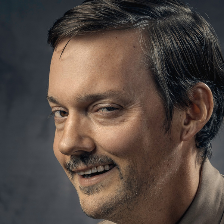

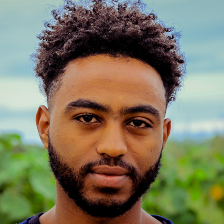

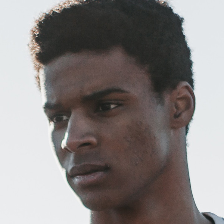

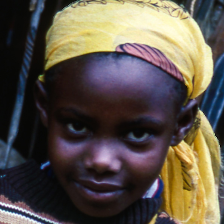

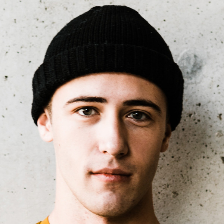

In [ ]:
from google.colab.patches import cv2_imshow

for i in img_list[:5,]:
  cv2_imshow(cv2.resize(i,(224,224)))

In [ ]:
# def test_bb(df,fname,title=""):

#   tst_img = cv2.imread(fname)
#   temp_df = df[df['Image_Name'] == fname]
#   rect_img = []
#   for rows in temp_df.index:
#     x = df['x'][rows]
#     y = df['y'][rows]
#     w = df['w'][rows]
#     h = df['h'][rows]
#     cv2.rectangle(tst_img,(x,y),(x+w,y+h),(255,0,0),2)
#     cv2.putText(tst_img, title, (int((x+w)*0.75),y-3),cv2.FONT_HERSHEY_SIMPLEX,0.5,(0,0,255))
#   cv2_imshow(tst_img)
  
#   return

In [ ]:
# def show_face(img_list,scale=1.0):

#   for imgs in img_list:
#     img = cv2.imread(imgs)
#     img_w  = int(img.shape[1]*scale)
#     img_h = int(img.shape[0]*scale)
#     img = cv2.resize(img,(img_w,img_h))
#     display(Markdown(f"#### {imgs}"))
#     cv2_imshow(img)

#   return

**2. Write a loop which will iterate through all the images in the ‘training_images’ folder and detect the faces present on all the images.**

In [ ]:
!wget https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml

--2022-12-25 15:42:14--  https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 930127 (908K) [text/plain]
Saving to: ‘haarcascade_frontalface_default.xml’

haarcascade_frontal 100%[===================>] 908.33K  --.-KB/s    in 0.03s   

2022-12-25 15:42:14 (28.8 MB/s) - ‘haarcascade_frontalface_default.xml’ saved [930127/930127]



0it [00:00, ?it/s]

Bounding Box parameters are `x`:132, `y`:162, `width`:349, `height`:349

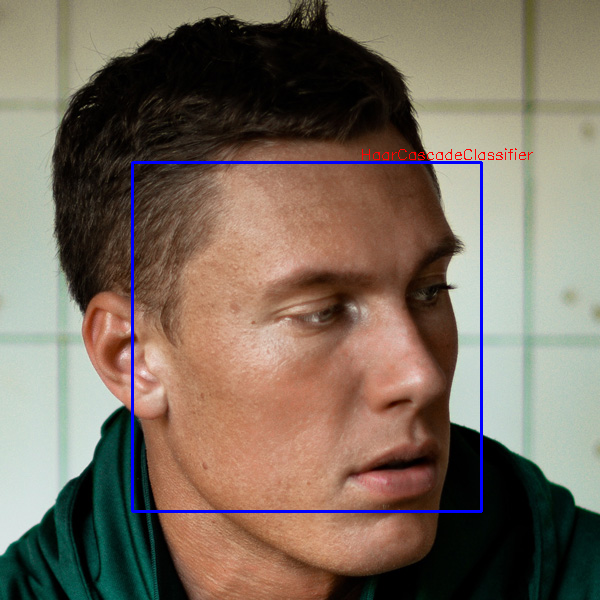

In [ ]:
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

for imgs, fnames in tqdm(zip(img_list,raw_img_file_names)):
  gray = cv2.cvtColor(imgs,cv2.COLOR_BGR2GRAY)
  faces = face_cascade.detectMultiScale(gray,1.1,4)


# Sample image from the looped images
test_img = cv2.imread(raw_img_file_names[24])
grey = cv2.cvtColor(test_img, cv2.COLOR_BGR2GRAY)
# Detect faces
faces = face_cascade.detectMultiScale(grey,1.1,4)
# Draw rectangle around the faces
for (x, y, w, h) in faces:
  cv2.rectangle(test_img, (x, y), (x+w, y+h), (255, 0, 0), 2)
  cv2.putText(test_img, "HaarCascadeClassifier", (int((x+w)*0.75),y-3),cv2.FONT_HERSHEY_SIMPLEX,0.5,(0,0,255))

# Display the output
display(Markdown(f"Bounding Box parameters are `x`:{x}, `y`:{y}, `width`:{w}, `height`:{h}"))
cv2_imshow(test_img)

**3. From the same loop above, extract metadata of the faces and write into a DataFrame.**

In [ ]:
haar_img_box_df = pd.DataFrame(columns=['x','y','w','h','Total_Faces','Image_Name'])
haar_img_box_df

,x,y,w,h,Total_Faces,Image_Name


In [ ]:
%%time
haar_undetected_images = []
haar_detected_images = []

for imgs, fnames in tqdm(zip(img_list,raw_img_file_names)):
  gray = cv2.cvtColor(imgs,cv2.COLOR_BGR2GRAY)
  faces = face_cascade.detectMultiScale(gray,1.1,4)
  if len(faces) == 0:
    haar_undetected_images.append(fnames)
    temp_dict = {'x':0, 
                 'y':0, 
                 'w':-1,
                 'h':-1, 
                 'Total_Faces':0,
                 'Image_Name':fnames} 
  else:
    haar_detected_images.append(fnames)
    for (x,y,w,h) in faces:
      temp_dict = {'x':x, 
                  'y':y, 
                  'w':w,
                  'h':h, 
                  'Total_Faces':len(faces),
                  'Image_Name':fnames} 
      haar_img_box_df = haar_img_box_df.append(temp_dict,ignore_index=True)
display(Markdown(f"#### Detected faces for {len(haar_detected_images)} images"))
display(Markdown(f"#### Failed to detect faces for {len(haar_undetected_images)} images"))

0it [00:00, ?it/s]

#### Detected faces for 930 images

#### Failed to detect faces for 161 images

CPU times: user 5min 21s, sys: 922 ms, total: 5min 22s
Wall time: 2min 53s


In [ ]:
haar_img_box_df

,x,y,w,h,Total_Faces,Image_Name
0,40,138,408,408,1,training_images/real_00079.jpg
1,89,83,52,52,2,training_images/real_00262.jpg
2,107,173,384,384,2,training_images/real_00262.jpg
3,106,153,386,386,1,training_images/real_00863.jpg
4,58,74,33,33,2,training_images/real_00973.jpg
...,...,...,...,...,...,...
1006,87,93,470,470,1,training_images/real_00492.jpg
1007,301,121,60,60,1,training_images/real_00103.jpg
1008,149,153,366,366,1,training_images/real_00930.jpg
1009,66,176,337,337,1,training_images/real_00051.jpg


**4. Save the output Dataframe in .csv format.**

In [ ]:
csv_data = haar_img_box_df.to_csv()

In [ ]:
csv_data

',x,y,w,h,Total_Faces,Image_Name\n0,40,138,408,408,1,training_images/real_00079.jpg\n1,89,83,52,52,2,training_images/real_00262.jpg\n2,107,173,384,384,2,training_images/real_00262.jpg\n3,106,153,386,386,1,training_images/real_00863.jpg\n4,58,74,33,33,2,training_images/real_00973.jpg\n5,161,123,345,345,2,training_images/real_00973.jpg\n6,77,110,418,418,1,training_images/real_00854.jpg\n7,147,143,424,424,2,training_images/real_00354.jpg\n8,77,343,56,56,2,training_images/real_00354.jpg\n9,33,121,362,362,1,training_images/real_00003.jpg\n10,17,84,466,466,2,training_images/real_00026.jpg\n11,121,358,130,130,2,training_images/real_00026.jpg\n12,434,76,97,97,2,training_images/real_00929.jpg\n13,105,202,382,382,2,training_images/real_00929.jpg\n14,48,119,433,433,1,training_images/real_00631.jpg\n15,109,151,409,409,1,training_images/real_00535.jpg\n16,111,160,415,415,1,training_images/real_00784.jpg\n17,54,205,354,354,1,training_images/real_01069.jpg\n18,131,236,336,336,1,training_images/real_0

# **Part C**

* <span style="color:#daad86">**DOMAIN**: <span style="color:#659dbd"> Face Recognition

* <span style="color:#daad86">**CONTEXT**: <span style="color:#659dbd">Company X intends to build a face identi ication model to recognise human faces.

* <span style="color:#daad86">**DATA DESCRIPTION**: <span style="color:#659dbd">The dataset comprises of images and its mask where there is a human face.
    
* <span style="color:#daad86">**PROJECT OBJECTIVE**: <span style="color:#659dbd">Face Aligned Face Dataset from Pinterest. This dataset contains 10,770 images for 100 people. All images are taken
from 'Pinterest' and aligned using dlib library. Some data samples:

**1. Unzip, read and Load data(‘PINS.zip’) into session.**

In [4]:
pins_path = "/content/drive/My Drive/AIML/Project2/Project2/PINS.zip"

In [ ]:
from zipfile import ZipFile

# specifying the zip file name
file_name = pins_path 
  
# opening the zip file in READ mode
with ZipFile(file_name, 'r') as zip:
    # printing all the contents of the zip file
    # zip.printdir()
  
    # extracting all the files
    print('Extracting all the files..')
    zip.extractall(path="/content/drive/My Drive/AIML/Project2/Project2/PINS/")
    #zip.printdir()
    print('END')

Extracting all the files..
END


In [5]:
directory = "/content/drive/My Drive/AIML/Project2/Project2/PINS/"

In [6]:
for filename in os.listdir(directory):
    os.rename(os.path.join(directory,filename),os.path.join(directory, filename.replace(' ', '_').upper()))
    str = "pins_"
    if str in filename:    
        filepath = os.path.join(directory, filename)
        newfilepath = os.path.join(directory, filename.replace(str, ""))
        os.rename(filepath, newfilepath)

for subdir, dirs, files in os.walk(directory):
    for file in files:
      os.rename(os.path.join(subdir, file), os.path.join(subdir, file.replace(' ', '_')))

In [7]:
import glob

paths = glob.glob("/content/drive/My Drive/AIML/Project2/Project2/PINS/PINS/*")
label_names = [os.path.split(x)[1] for x in paths]

print("Total labels: {}".format(len(label_names)))
print("Labels: {}".format((label_names)))

Total labels: 100
Labels: ['pins_Aaron Paul', 'pins_alexandra daddario', 'pins_Alvaro Morte', 'pins_alycia debnam carey face', 'pins_Amanda Crew', 'pins_Amaury Nolasco', 'pins_amber heard face', 'pins_Anna Gunn', 'pins_anne hathaway', 'pins_barbara palvin face', 'pins_bellamy blake face', 'pins_Benedict Cumberbatch', 'pins_Betsy Brandt', 'pins_bill gates', 'pins_Brenton Thwaites', 'pins_brie larson', 'pins_Brit Marling', 'pins_Bryan Cranston', 'pins_Caity Lotz', 'pins_Cameron Monaghan', 'pins_chadwick boseman face', 'pins_Chance Perdomo', 'pins_Chris Evans', 'pins_Chris Pratt', 'pins_Cobie Smulders', 'pins_Danielle Panabaker', 'pins_Dave Franco', 'pins_david mazouz', 'pins_Dominic Purcell', 'pins_drake', 'pins_dua lipa face', 'pins_Dwayne Johnson', 'pins_eliza taylor', 'pins_elizabeth olsen face', 'pins_elon musk', 'pins_Emilia Clarke', 'pins_Emily Bett Rickards', 'pins_Emma Stone', 'pins_emma watson face', 'pins_gal gadot face', 'pins_grant gustin face', 'pins_Gwyneth Paltrow', 'pins_

In [8]:
df = pd.DataFrame(columns=['Person', 'No. of Images','File Path', 'Files'])

folders = [x[0] for x in os.walk(directory)]

for subfolders in folders:
  fileList = os.listdir(subfolders)
  filePath = os.path.abspath(subfolders)
  person = (subfolders)[len(directory):]
  df = df.append({'Person': person, 'No. of Images': len(fileList), 'File Path': filePath , 'Files': fileList}, ignore_index=True)

df

,Person,No. of Images,File Path,Files
0,,1,/content/drive/My Drive/AIML/Project2/Project2...,[PINS]
1,PINS,100,/content/drive/My Drive/AIML/Project2/Project2...,"[pins_Aaron Paul, pins_alexandra daddario, pin..."
2,PINS/pins_Aaron Paul,86,/content/drive/My Drive/AIML/Project2/Project2...,"[Aaron_Paul0_262.jpg, Aaron_Paul101_247.jpg, A..."
3,PINS/pins_alexandra daddario,165,/content/drive/My Drive/AIML/Project2/Project2...,"[alexandra_daddario0.jpg, alexandra_daddario1...."
4,PINS/pins_Alvaro Morte,91,/content/drive/My Drive/AIML/Project2/Project2...,"[Alvaro_Morte1_799.jpg, Alvaro_Morte100_825.jp..."
...,...,...,...,...
97,PINS/pins_Ursula Corbero,80,/content/drive/My Drive/AIML/Project2/Project2...,"[Ursula_Corbero1_2410.jpg, Ursula_Corbero10_23..."
98,PINS/pins_Wentworth Miller,113,/content/drive/My Drive/AIML/Project2/Project2...,"[Wentworth_Miller0.jpg, Wentworth_Miller10.jpg..."
99,PINS/pins_Willa Holland,147,/content/drive/My Drive/AIML/Project2/Project2...,"[Willa_Holland0.jpg, Willa_Holland1.jpg, Willa..."
100,PINS/pins_William Fichtner,139,/content/drive/My Drive/AIML/Project2/Project2...,"[William_Fichtner0.jpg, William_Fichtner1.jpg,..."


**2. Write function to create metadata of the image.**

In [9]:
from glob import glob
images = []
classes=[]
missing=0
for class_folder_name in os.listdir(directory+"PINS"):
    class_folder_path = os.path.join(directory+"PINS", class_folder_name)
    class_label = class_folder_name
    
    for image_path in glob(os.path.join(class_folder_path, "*.jpg")):
        image_bgr = cv2.imread(image_path, cv2.IMREAD_COLOR)
        if image_bgr is None: # if the file contain any missing value ignore it
          missing += 1
          continue
        images.append(image_bgr)
        
        classes.append(class_label)

In [10]:
# resize image
def resize_images(img):

  img = np.array(img).astype(np.uint8)
  #print(img.dtype)
  res = cv2.resize(img,(224,224), interpolation = cv2.INTER_CUBIC)
  return res

#save resized images into images.
images = [resize_images(img) for img in images]

In [11]:
#see number of images in each label
images = np.array(images)
classes = np.array(classes)
print("images shape: ", images.shape)
print("classes shape: ", classes.shape)

images shape:  (10770, 224, 224, 3)
classes shape:  (10770,)


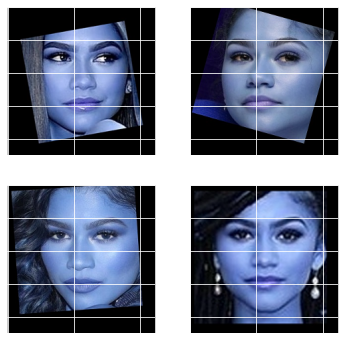

In [12]:
def plot_for_class(label):
    nb_rows = 2
    nb_cols = 2
    fig, axs = plt.subplots(nb_rows, nb_cols, figsize=(6, 6))
    class_images =images[classes== label]
    n = 0
    for i in range(0, nb_rows):
        for j in range(0, nb_cols):
            axs[i, j].xaxis.set_ticklabels([])
            axs[i, j].yaxis.set_ticklabels([])
            axs[i, j].imshow(class_images[n])
            n += 1 
plot_for_class("pins_zendaya")

**3. Write a loop to iterate through each and every image and create metadata for all the images.**

In [13]:
import numpy as np
import os

class IdentityMetadata():
    def __init__(self, base, name, file):
        # print(base, name, file)
        # dataset base directory
        self.base = base
        # identity name
        self.name = name
        # image file name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file) 
    
def load_metadata(path):
    metadata = []
    for i in os.listdir(path):
        for f in os.listdir(os.path.join(path, i)):
            # Allow only jpg/jpeg' files.
            ext = os.path.splitext(f)[1]
            if ext == '.jpg' or ext == '.jpeg':
                metadata.append(IdentityMetadata(path, i, f))
    return np.array(metadata)

# metadata = load_metadata('images')
metadata = load_metadata(directory+"PINS")

In [14]:
metadata.shape

(10770,)

**4. Generate Embeddings vectors on the each face in the dataset.**

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ZeroPadding2D, Convolution2D, MaxPooling2D, Dropout, Flatten, Activation

def vgg_face():	
    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(Convolution2D(4096, (7, 7), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(4096, (1, 1), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(2622, (1, 1)))
    model.add(Flatten())
    model.add(Activation('softmax'))
    return model

In [16]:
model = vgg_face()
model.load_weights('/content/drive/My Drive/AIML/Project2/Project2/vgg_face_weights.h5')

In [17]:
model.layers[0], model.layers[-2]

(<keras.layers.reshaping.zero_padding2d.ZeroPadding2D at 0x7f80d3445700>,
 <keras.layers.reshaping.flatten.Flatten at 0x7f80ccea1700>)

In [18]:
from tensorflow.keras.models import Model
vgg_face_descriptor = Model(inputs=model.layers[0].input, outputs=model.layers[-2].output)

In [19]:
vgg_face_descriptor.inputs, vgg_face_descriptor.outputs

([<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'zero_padding2d_input')>],
 [<KerasTensor: shape=(None, 2622) dtype=float32 (created by layer 'flatten')>])

In [20]:
import cv2
def load_image(path):
    img = cv2.imread(path,1)
    # OpenCV loads images with color channels
    # in BGR order. So we need to reverse them
    print('Image Dimensions :', img.shape)
    return img[...,::-1]

In [21]:
# Get embedding vector for first image in the metadata using the pre-trained model
img_path = metadata[100].image_path()
img = load_image(img_path)

# Normalising pixel values from [0-255] to [0-1]: scale RGB values to interval [0,1]
img = (img / 255.).astype(np.float32)
img = cv2.resize(img, dsize = (224,224))
print(img.shape)

# Obtain embedding vector for an image
# Get the embedding vector for the above image using vgg_face_descriptor model and print the shape 
embedding_vector = vgg_face_descriptor.predict(np.expand_dims(img, axis=0))[0]
print(embedding_vector.shape)

Image Dimensions : (299, 299, 3)
(224, 224, 3)
1/1 [==============================] - 1s 794ms/step
(2622,)


In [22]:
embedding_vector[0], type(embedding_vector), type(embedding_vector[0])

(0.017099105, numpy.ndarray, numpy.float32)

In [23]:
embedding_vector[2], embedding_vector[98], embedding_vector[-2]

(0.007062317, -0.0140638165, 0.022173652)

In [24]:
total_images = len(metadata)

In [25]:
len(metadata)
# plt.imshow(img1)

10770

In [27]:
embeddings = np.zeros((metadata.shape[0], 2622))
for i, m in enumerate(metadata):
    img_path = metadata[i].image_path()
    img = load_image(img_path)
    img = (img / 255.).astype(np.float32)
    img = cv2.resize(img, dsize = (224,224))
    embedding_vector = vgg_face_descriptor.predict(np.expand_dims(img, axis=0))[0]
    embeddings[i]=embedding_vector

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 405ms/step
Image Dimensions : (299, 299, 3)
1/1 [==============================] - 0s 413ms/step
Image Dimensions : (299, 299, 3)
1/1 [==============================] - 0s 408ms/step
Image Dimensions : (299, 299, 3)
1/1 [==============================] - 0s 412ms/step
Image Dimensions : (299, 299, 3)
1/1 [==============================] - 0s 409ms/step
Image Dimensions : (299, 299, 3)
1/1 [==============================] - 0s 408ms/step
Image Dimensions : (299, 299, 3)
1/1 [==============================] - 0s 413ms/step
Image Dimensions : (299, 299, 3)
1/1 [==============================] - 0s 428ms/step
Image Dimensions : (299, 299, 3)
1/1 [==============================] - 0s 424ms/step
Image Dimensions : (299, 299, 3)
1/1 [==============================] - 0s 409ms/step
Image Dimensions : (299, 299, 3)
1/1 [==============================] - 0s 429ms/step
Image Dimensions : (299, 299, 3)
1/1

In [28]:
print('embeddings shape :', embeddings.shape)

embeddings shape : (10770, 2622)


**5. Build distance metrics for identifying the distance between two similar and dissimilar images.**

In [29]:
from scipy.spatial.distance import cosine
def distance(emb1, emb2):
    # return np.sum(np.square(emb1 - emb2))
    return cosine(emb1, emb2)

Image Dimensions : (299, 299, 3)
Image Dimensions : (299, 299, 3)
Image Dimensions : (299, 299, 3)
Image Dimensions : (299, 299, 3)


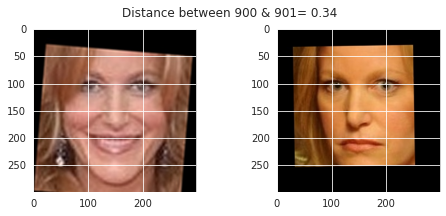

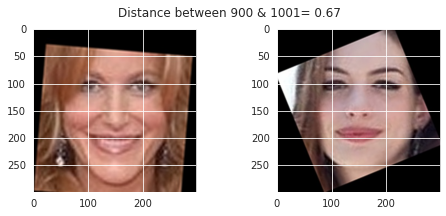

In [30]:
def show_pair(idx1, idx2):
    plt.figure(figsize=(8,3))
    plt.suptitle(f'Distance between {idx1} & {idx2}= {distance(embeddings[idx1], embeddings[idx2]):.2f}')
    plt.subplot(121)
    plt.imshow(load_image(metadata[idx1].image_path()))
    plt.subplot(122)
    plt.imshow(load_image(metadata[idx2].image_path()));    

show_pair(900, 901)
show_pair(900, 1001)

**6. Use PCA for dimensionality reduction.**

In [31]:
from sklearn.preprocessing import LabelEncoder

enc = LabelEncoder()
y = enc.fit_transform(classes)

num_classes = len(np.unique(y))
num_classes

100

In [32]:
X_train, X_test, y_train, y_test = train_test_split(embeddings, y, test_size=0.3, random_state=50)

In [33]:
print('X_train shape : ({0},{1})'.format(X_train.shape[0], X_train.shape[1]))
print('y_train shape : ({0},)'.format(y_train.shape[0]))
print('X_test shape : ({0},{1})'.format(X_test.shape[0], X_test.shape[1]))
print('y_test shape : ({0},)'.format(y_test.shape[0]))

X_train shape : (7539,2622)
y_train shape : (7539,)
X_test shape : (3231,2622)
y_test shape : (3231,)


In [34]:
y_test[0], y_train[988]

(62, 53)

In [35]:
# Standarize features
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)

In [36]:
X_test_std = scaler.transform(X_test)

In [37]:
from sklearn.decomposition import PCA

pca = PCA(n_components=128)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

In [38]:
print('X_train_std shape : ({0},{1})'.format(X_train_std.shape[0], X_train_std.shape[1]))
print('y_train_encoded shape : ({0},)'.format(y_train.shape[0]))
print('X_test_std shape : ({0},{1})'.format(X_test_std.shape[0], X_test_std.shape[1]))
print('y_test_encoded shape : ({0},)'.format(y_test.shape[0]))

X_train_std shape : (7539,2622)
y_train_encoded shape : (7539,)
X_test_std shape : (3231,2622)
y_test_encoded shape : (3231,)


In [39]:
from sklearn.decomposition import PCA

pca = PCA(n_components=128)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

**7. Build an SVM classi ier in order to map each image to its right person.**

In [40]:
from sklearn.svm import SVC

clf = SVC(C=5., gamma=0.001)
clf.fit(X_train_pca, y_train)

SVC(C=5.0, gamma=0.001)

In [41]:
y_predict = clf.predict(X_test_pca)

In [42]:
print('y_predict : ',y_predict)
print('y_test : ',y_test)

y_predict :  [62 12 58 ...  0 33 88]
y_test :  [62 12 58 ...  0 33 88]


In [43]:
y_predict_encoded = enc.inverse_transform(y_predict)

In [44]:
print('y_predict_encoded : ',y_predict_encoded)

y_predict_encoded :  ['pins_William Fichtner' 'pins_Chance Perdomo' 'pins_Tom Cavanagh' ...
 'pins_Aaron Paul' 'pins_Kumail Nanjiani' 'pins_mark zuckerberg']


In [45]:
print('y_predict shape : ', y_predict.shape)
print('y_test_encoded shape : ', y_test.shape)

y_predict shape :  (3231,)
y_test_encoded shape :  (3231,)


In [46]:
from sklearn.metrics import precision_recall_curve,accuracy_score,f1_score,precision_score,recall_score
accuracy_score(y_test, y_predict)

0.9427421850820179

**8. Import and display the the test images.**

In [54]:
disp1 = load_image("/content/drive/My Drive/AIML/Project2/Project2/Benedict Cumberbatch9.jpg")
disp2 = load_image("/content/drive/My Drive/AIML/Project2/Project2/Dwayne Johnson4.jpg")

Image Dimensions : (299, 299, 3)
Image Dimensions : (299, 299, 3)


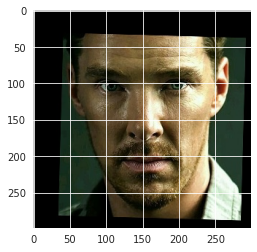

In [55]:
plt.imshow(disp1)

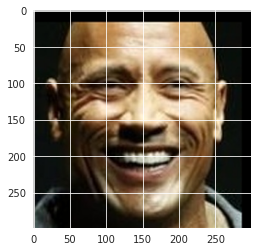

In [56]:
plt.imshow(disp2)

**9. Use the trained SVM model to predict the face on both test images.**

In [48]:
example_image1 = load_image("/content/drive/My Drive/AIML/Project2/Project2/Benedict Cumberbatch9.jpg")
img1 = (example_image1 / 255.).astype(np.float32)
img1 = cv2.resize(img1, dsize = (224,224))
embedding_example1 = vgg_face_descriptor.predict(np.expand_dims(img1, axis=0))[0]
embedding_example1 = embedding_example1.reshape(1,embedding_example1.shape[0])
embedding_example1.shape
embed_std1 = scaler.transform(embedding_example1)
embed_pca1 = pca.transform(embed_std1)

Image Dimensions : (299, 299, 3)
1/1 [==============================] - 1s 988ms/step


In [49]:
pred_svm1 = clf.predict(embed_pca1)[0]
print(f"The predicted label is:'{pred_svm1}'")

The predicted label is:'5'


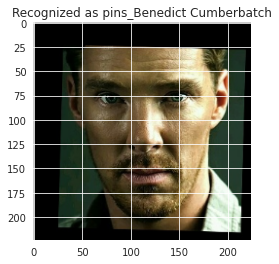

In [50]:
example_identity1 = enc.inverse_transform(np.ravel(pred_svm1))[0]

plt.imshow(img1)
plt.title(f'Recognized as {example_identity1}');

In [51]:
example_image2 = load_image("/content/drive/My Drive/AIML/Project2/Project2/Dwayne Johnson4.jpg")
img2 = (example_image2 / 255.).astype(np.float32)
img2 = cv2.resize(img2, dsize = (224,224))
embedding_example2 = vgg_face_descriptor.predict(np.expand_dims(img2, axis=0))[0]
embedding_example2 = embedding_example2.reshape(1,embedding_example2.shape[0])
embedding_example2.shape
embed_std2 = scaler.transform(embedding_example2)
embed_pca2 = pca.transform(embed_std2)

Image Dimensions : (299, 299, 3)
1/1 [==============================] - 0s 414ms/step


In [52]:
pred_svm2 = clf.predict(embed_pca2)[0]
print(f"The predicted label is:'{pred_svm2}'")

The predicted label is:'19'


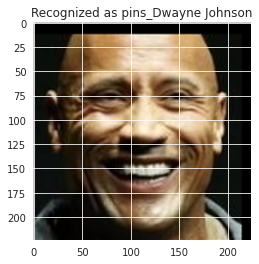

In [53]:
example_identity2 = enc.inverse_transform(np.ravel(pred_svm2))[0]

plt.imshow(img2)
plt.title(f'Recognized as {example_identity2}');